# Numerical Simulation of 2D Steady-State Flow on XCT images

This code solves 2D steady-state flow problems in heterogeneous 
porous media with the Finite Difference Method (FDM) approach.

**PDE problem**:
$$ 
\frac{\partial}{\partial x} \left( k \frac{\rho}{\mu} \frac{\partial P}{\partial x} \right) + \frac{\partial}{\partial y} \left( k \frac{\rho}{\mu} \frac{\partial P}{\partial y} \right) = 0 
$$

**Boundary conditions**:
- $ P = 2 $ kPa at  x = 0 
- $ P = 1 $ kPa at  x = 1 
- $ \frac{\partial P}{\partial y} = 0 $ at y = 0 and  y = 1

**Developed by**:
Lal Mamud, Postdoc - Subsurface Modeler, Environmental Subsurface Science Group, Energy & Environment Division, Pacific Northwest National Laboratory, Richland, WA, USA.

**Mentors**:
Maruti K. Mudunuru and Satish Karra

## Imports Python packages and functions

In [1]:
import sys
import os
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import gstools as gs
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
%load_ext autoreload
%autoreload 2

# import functions
current_directory = os.getcwd()                             # current directory
parent_directory = os.path.dirname(current_directory)       # parent directory
sys.path.append(parent_directory)                           # Add the parent directory to sys.path
from src.flow.plotting_results import *

## Loading XCT Data
In this section, we load the XCT data from the file for domain and variable declarations and plot normalized XCT data.

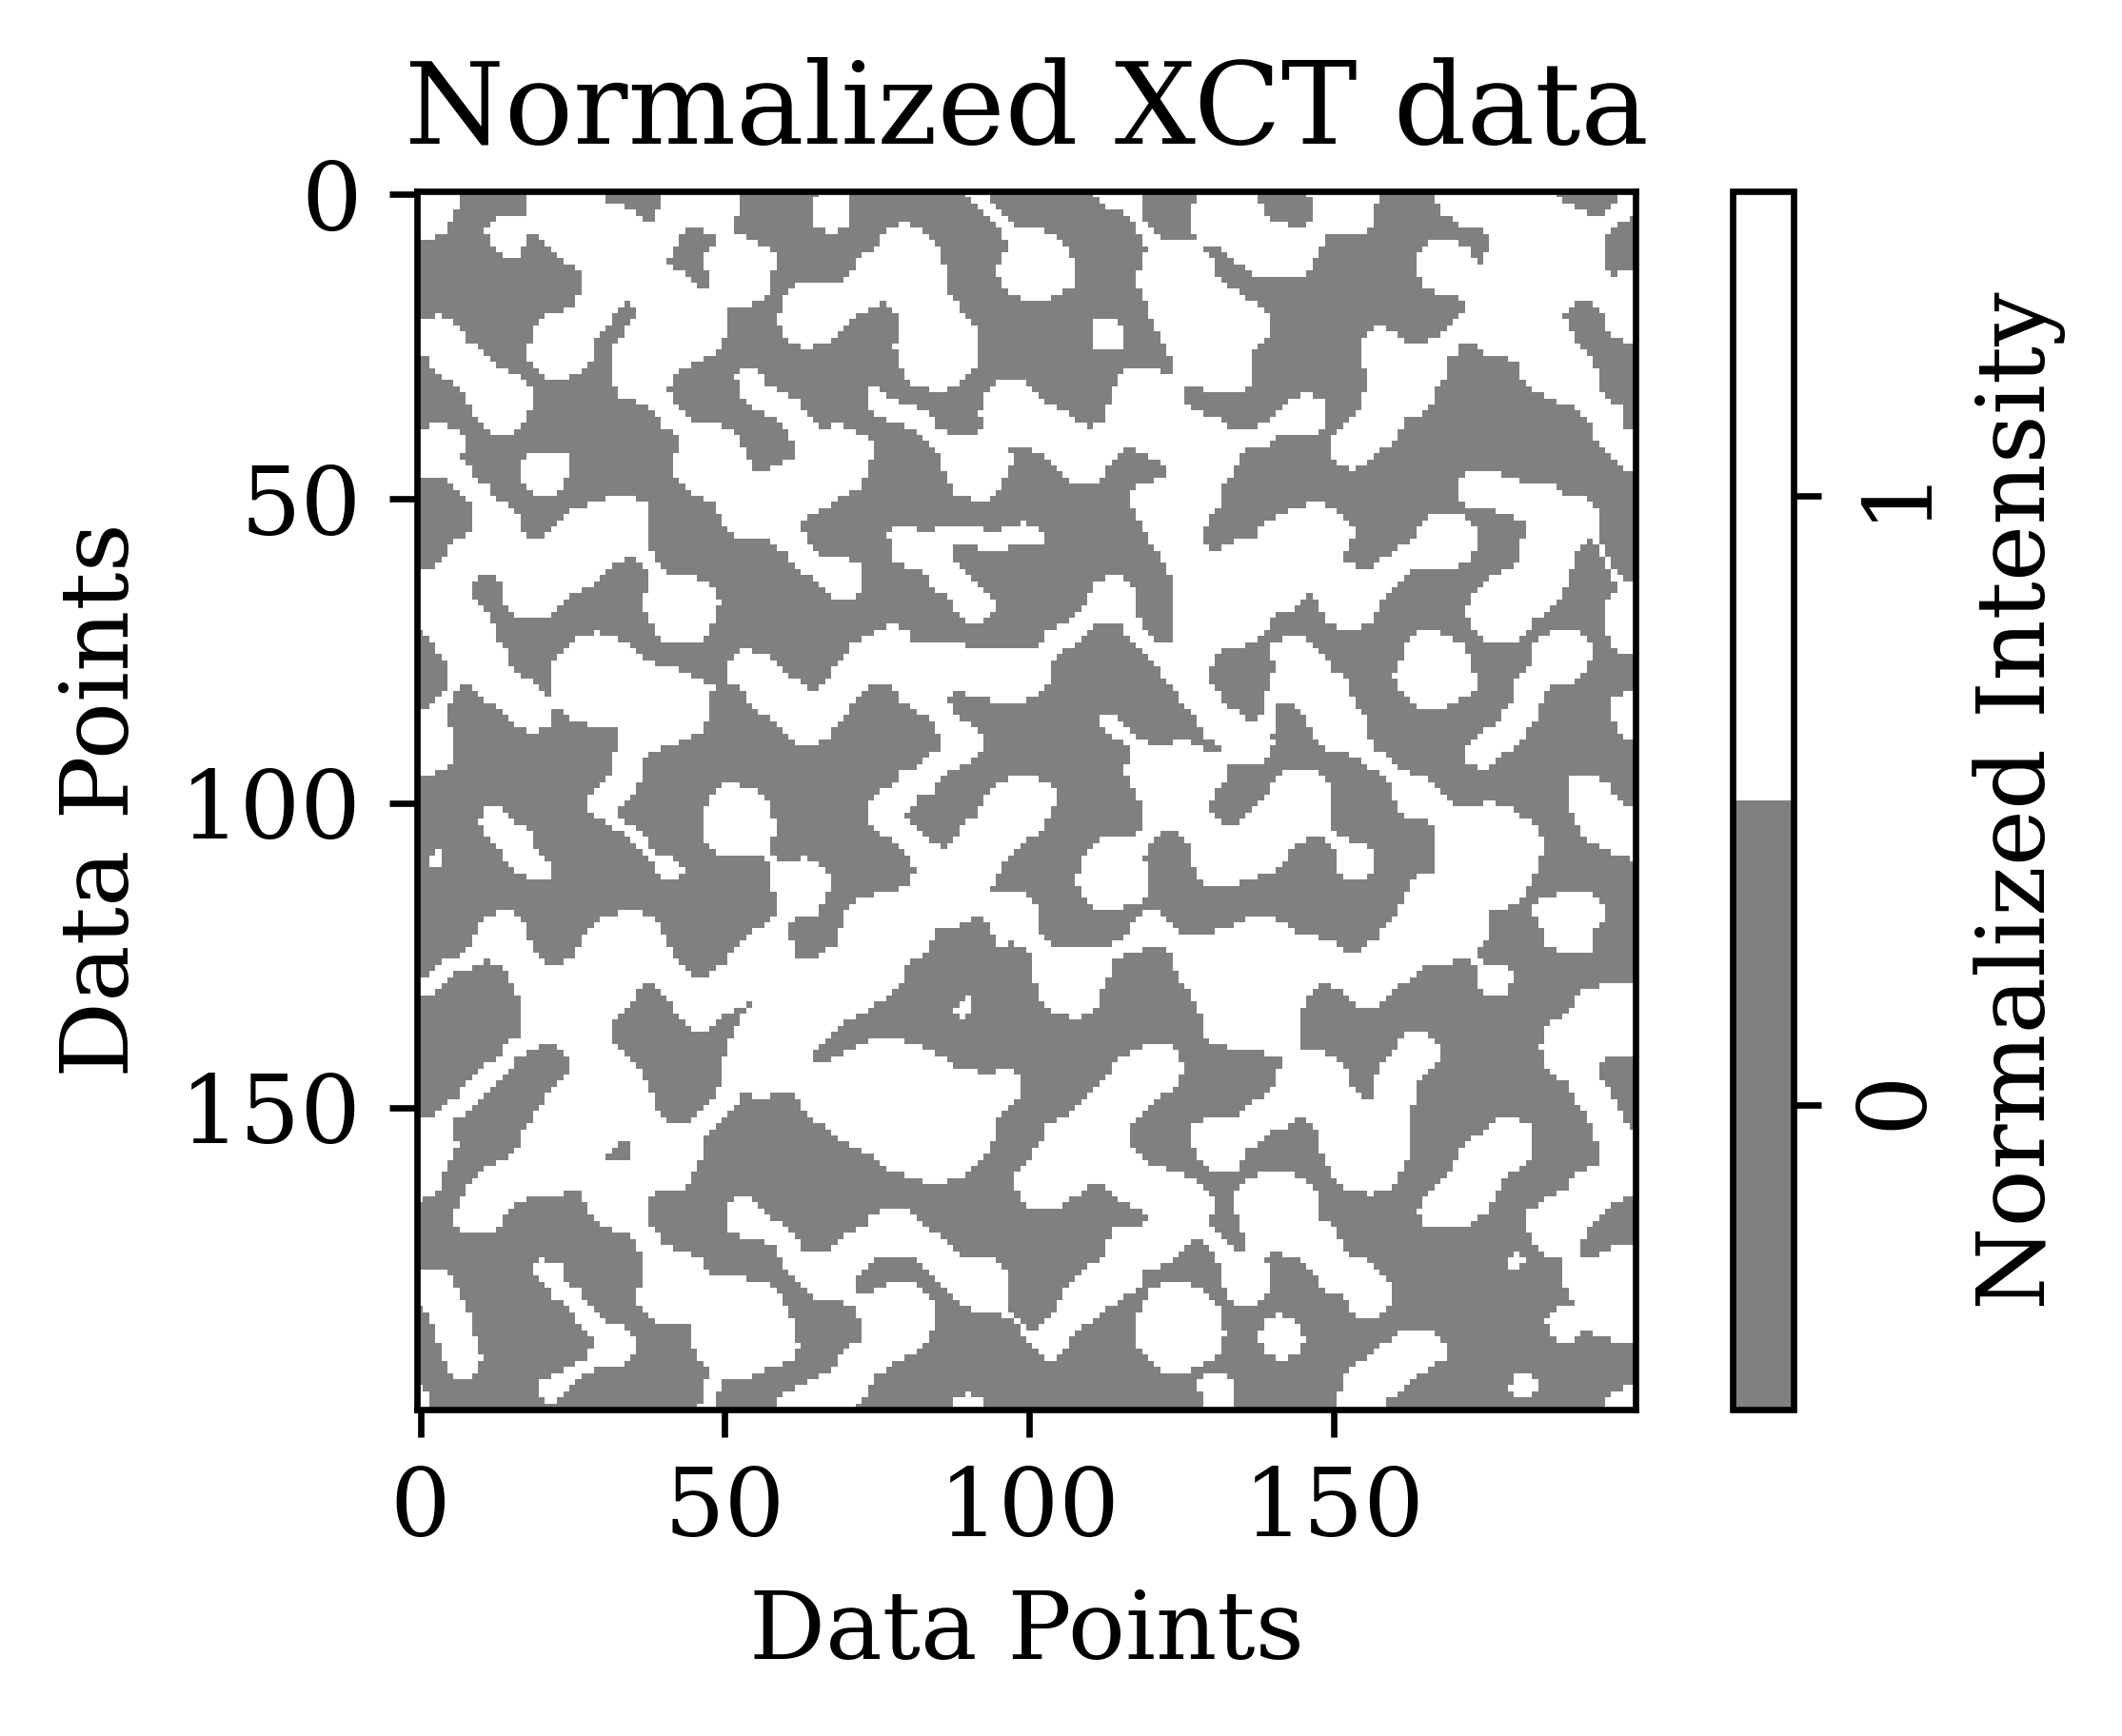

In [2]:
#%% loading XCT data from the file for domain and variable declarations
data_dir = "../example_outputs/"
results_dir = "../example_outputs/flow/"

data = np.load(data_dir + 'micromodel.npy')
normalized_xct_data = data/np.max(data)
plot_2d_xct_data_seg(normalized_xct_data, results_dir)

# Dimensions of the data
data_width, data_height = len(normalized_xct_data), len(normalized_xct_data) 

# Generate evenly spaced points in the interval [0, 1] for both dimensions
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0 , 1.0
x = np.linspace(xmin, xmax, data_width*1)
dx = x[1] - x[0]
nx = len(x)
y = np.linspace(ymin, ymax, data_height*1)
dy = y[1] - y[0]
ny = len(y)
X, Y = np.meshgrid(x, y)

## Permeability Field Generation
We generate the permeability field based on the XCT data and plot the distribution.

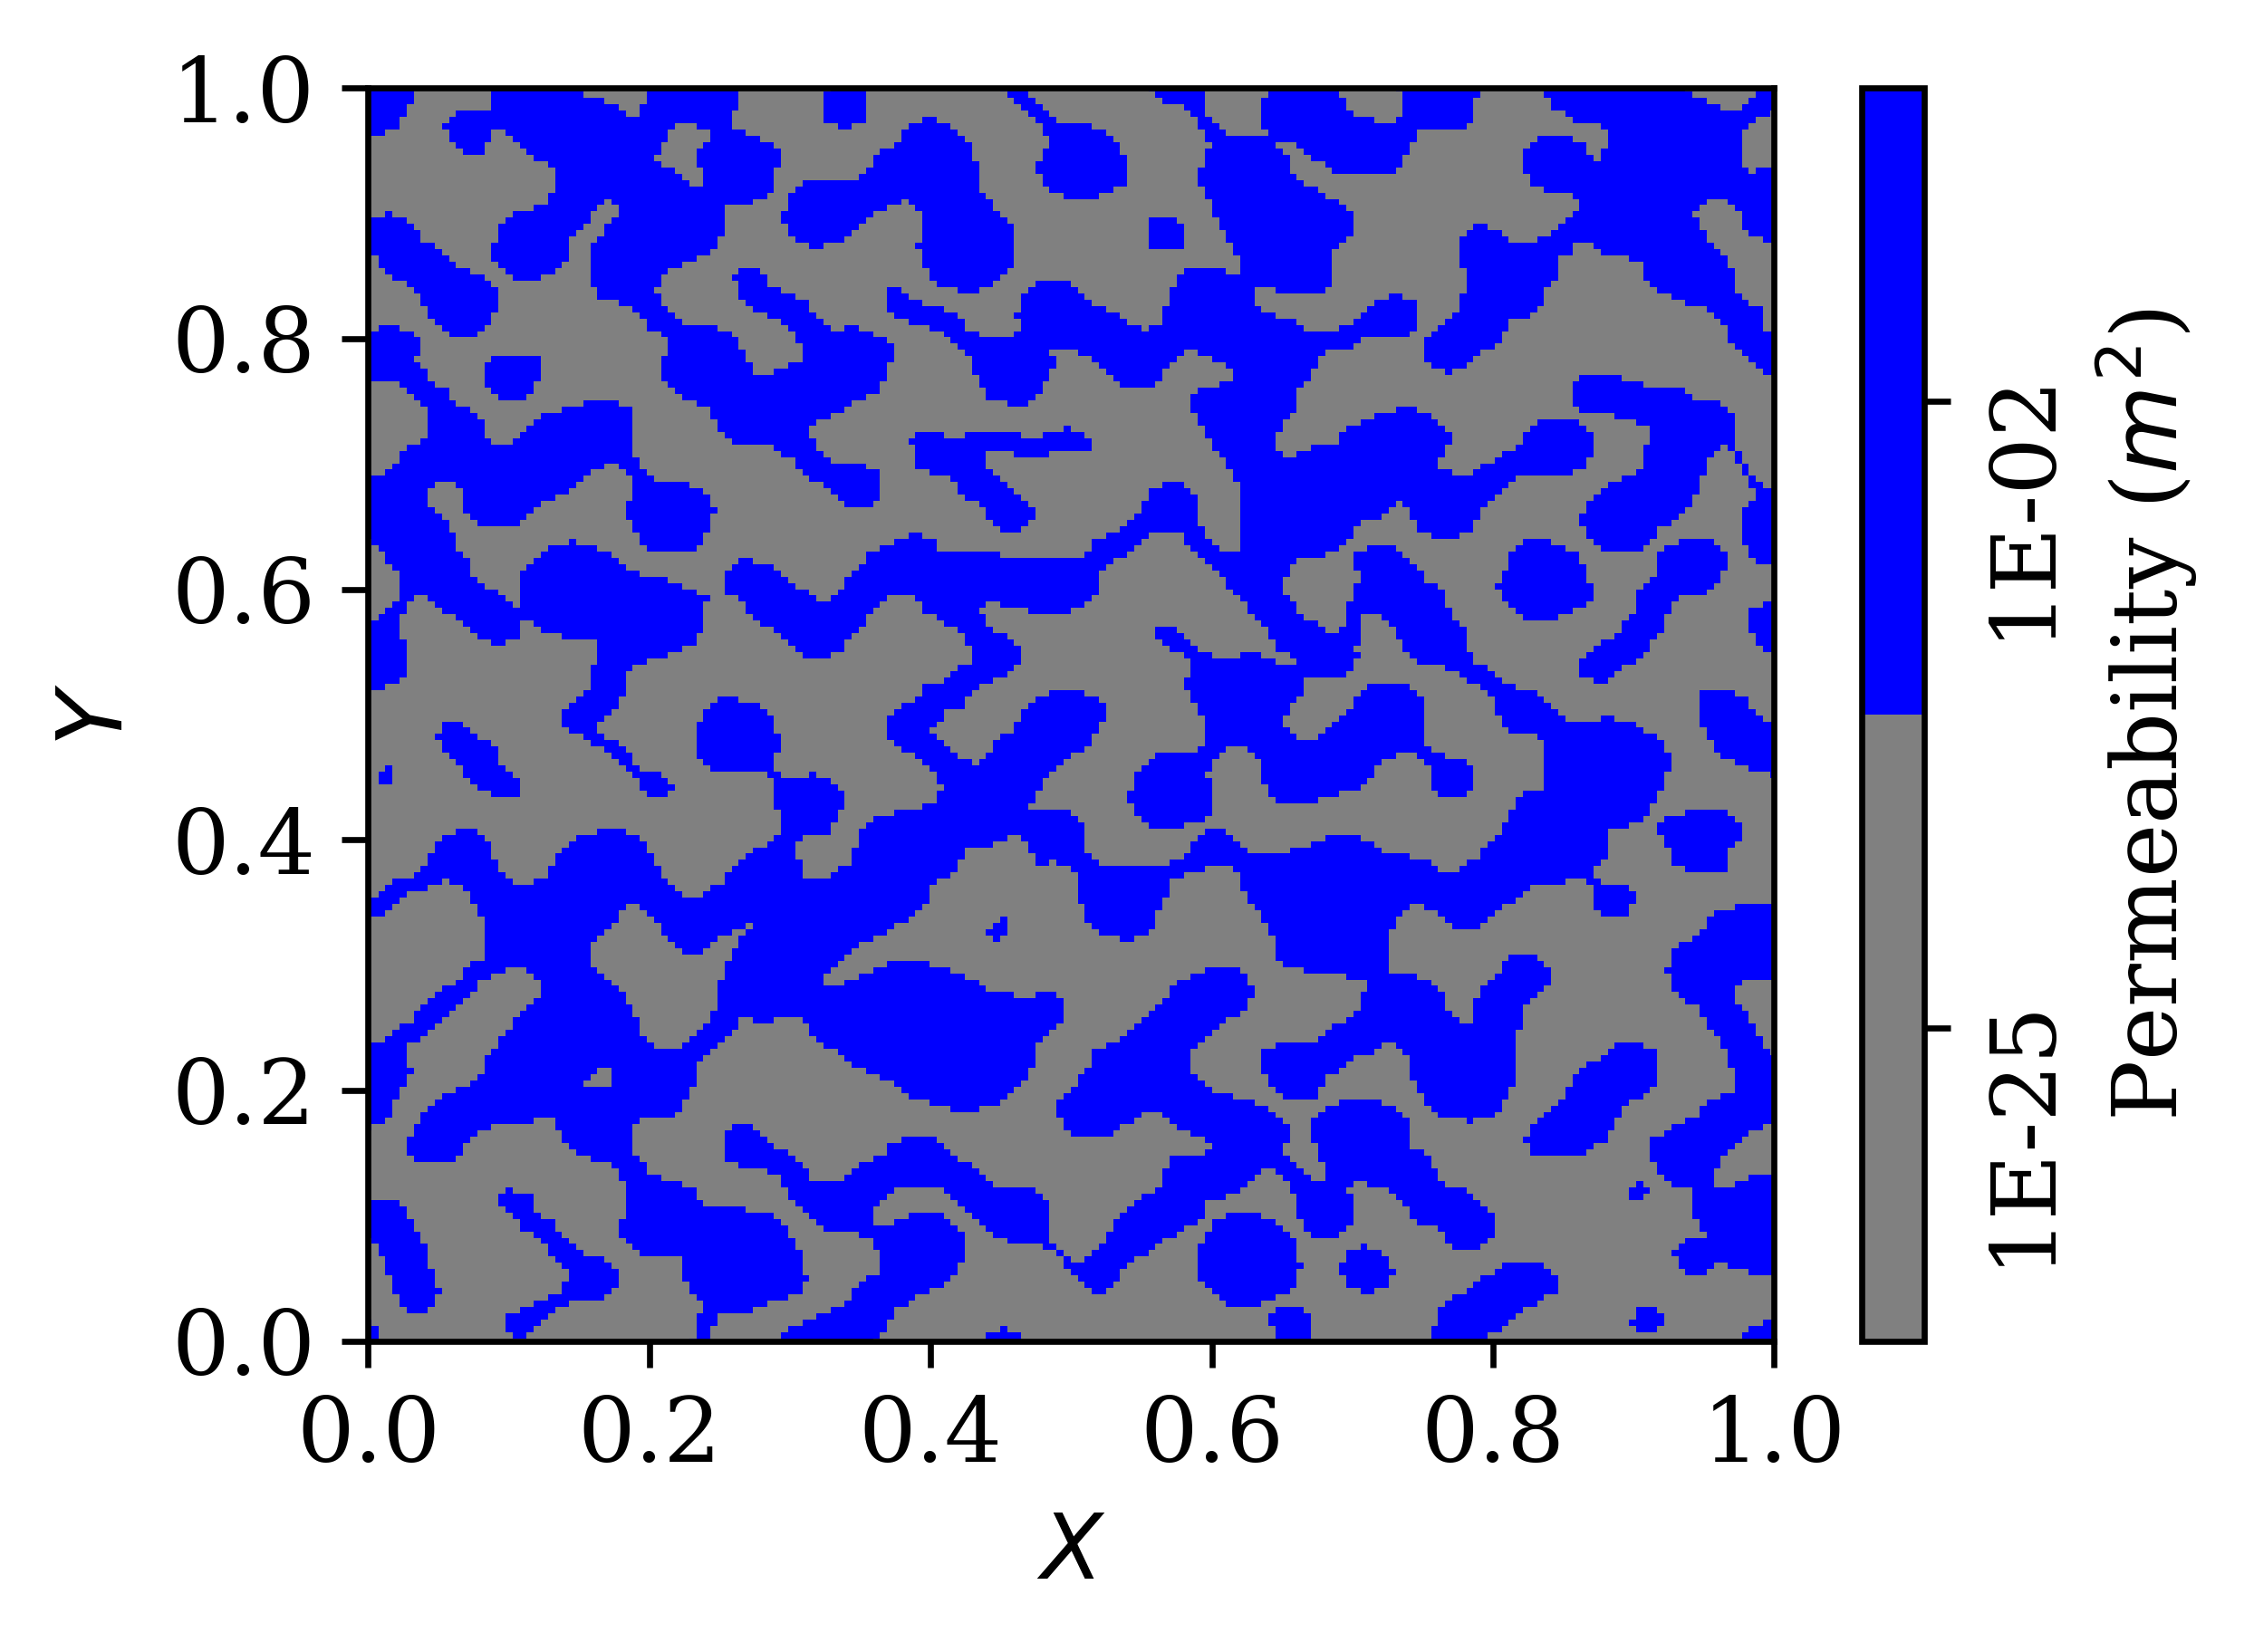

In [3]:
# Permeability field generation based on the XCT data
k_min = 1E-25       # Assigned Permeability of soil matrix corresponding to the lower XCT values (1 𝑚^2/s)
k_max = 1E-2         # Assigned Permeability of pores corresponding to the higher XCT values (1 𝑚^2/s)

# Find the minimum and maximum values of xct_xy_slice
xct_val_min = np.min(normalized_xct_data)
xct_val_max = np.max(normalized_xct_data)

perm_field_as_XCT = np.full_like(normalized_xct_data, fill_value = k_min)  
perm_field_as_XCT[normalized_xct_data == np.max(normalized_xct_data)] = k_max   
perm_field = np.flipud(perm_field_as_XCT)
plot_2d_permeability_seg(X, Y, perm_field, results_dir)

## Boundary Conditions and Input Parameters
Here, we define the boundary conditions and input parameters for the 2D numerical flow simulation on XCT image.

In [4]:
# Define the boundary conditions and input parameters
P1 = 2.0             # at x = 0 for all y, Dirichlet boundary at the left (kPa)
P2 = 1.0             # at x = 1 for all y, Dirichlet boundary at the right (kPa)
dP_dy1 = 0           # at y = 0 for all x, Neumann boundary at the bottom (kPa)
dP_dy2 = 0           # at y = 1 for all x, Neumann boundary at the top (kPa)

# Input parameters: Dynamic viscosity (mu), Density of water (rho), and Permeability (k)
rho = 998                                # Density of water in kg/m³
mu = 1.002E-6                            # Dynamic viscosity (kPa·s)
coeff = perm_field * rho / mu            # Coefficient of Permeability calculations (k*rho/mu)


## Numerical solution
Initialize the hydraulic pressure matrix and set up the finite difference coefficients.

In [6]:
# Initialize the hydraulic Pressure matrix
P = np.ones((nx, ny))  # Source term (example)

# Define the finite difference coefficients
a = 1 / dx**2
b1 = 1 / dy**2
c = -2 * (a + b1)

A = np.zeros((nx * ny, nx * ny))
b = np.zeros(nx * ny)

for k in range(nx * ny):
    i = k // ny
    j = k % ny
    
    if i == 0:  # Bottom boundary with Neumann condition
        A[k, k] = -1 / dy
        A[k, k + ny] = 1 / dy
        b[k] = dP_dy1  # Neumann condition
        
    elif i == nx - 1:  # Top boundary with Neumann condition
        A[k, k] = 1 / dy
        A[k, k - ny] = -1 / dy
        b[k] = dP_dy2  # Neumann condition
        
    elif j == 0:  # Left boundary with Dirichlet condition
        A[k, k] = 1
        b[k] = 2  # Dirichlet condition
        
    elif j == ny - 1:  # Right boundary with Dirichlet condition
        A[k, k] = 1
        b[k] = 1  # Dirichlet condition
        
    else:  # Interior points
        A[k, k - ny] = coeff[i, j] * a
        A[k, k - 1] = coeff[i, j] * b1
        A[k, k] = coeff[i, j] * c
        A[k, k + 1] = coeff[i, j] * b1
        A[k, k + ny] = coeff[i, j] * a

# Solve the linear system Ax = b
P_flat = np.linalg.solve(A, b)

# Compute the residual
residual = b - A.dot(P_flat)
residual_norm = np.linalg.norm(residual)
print("Residual Norm:", residual_norm)

# Reshape the solution vector into a 2D array
Pressure = P_flat.reshape((nx, ny))

Residual Norm: 0.02339207698109722


## Plot the results of the Numerical solution

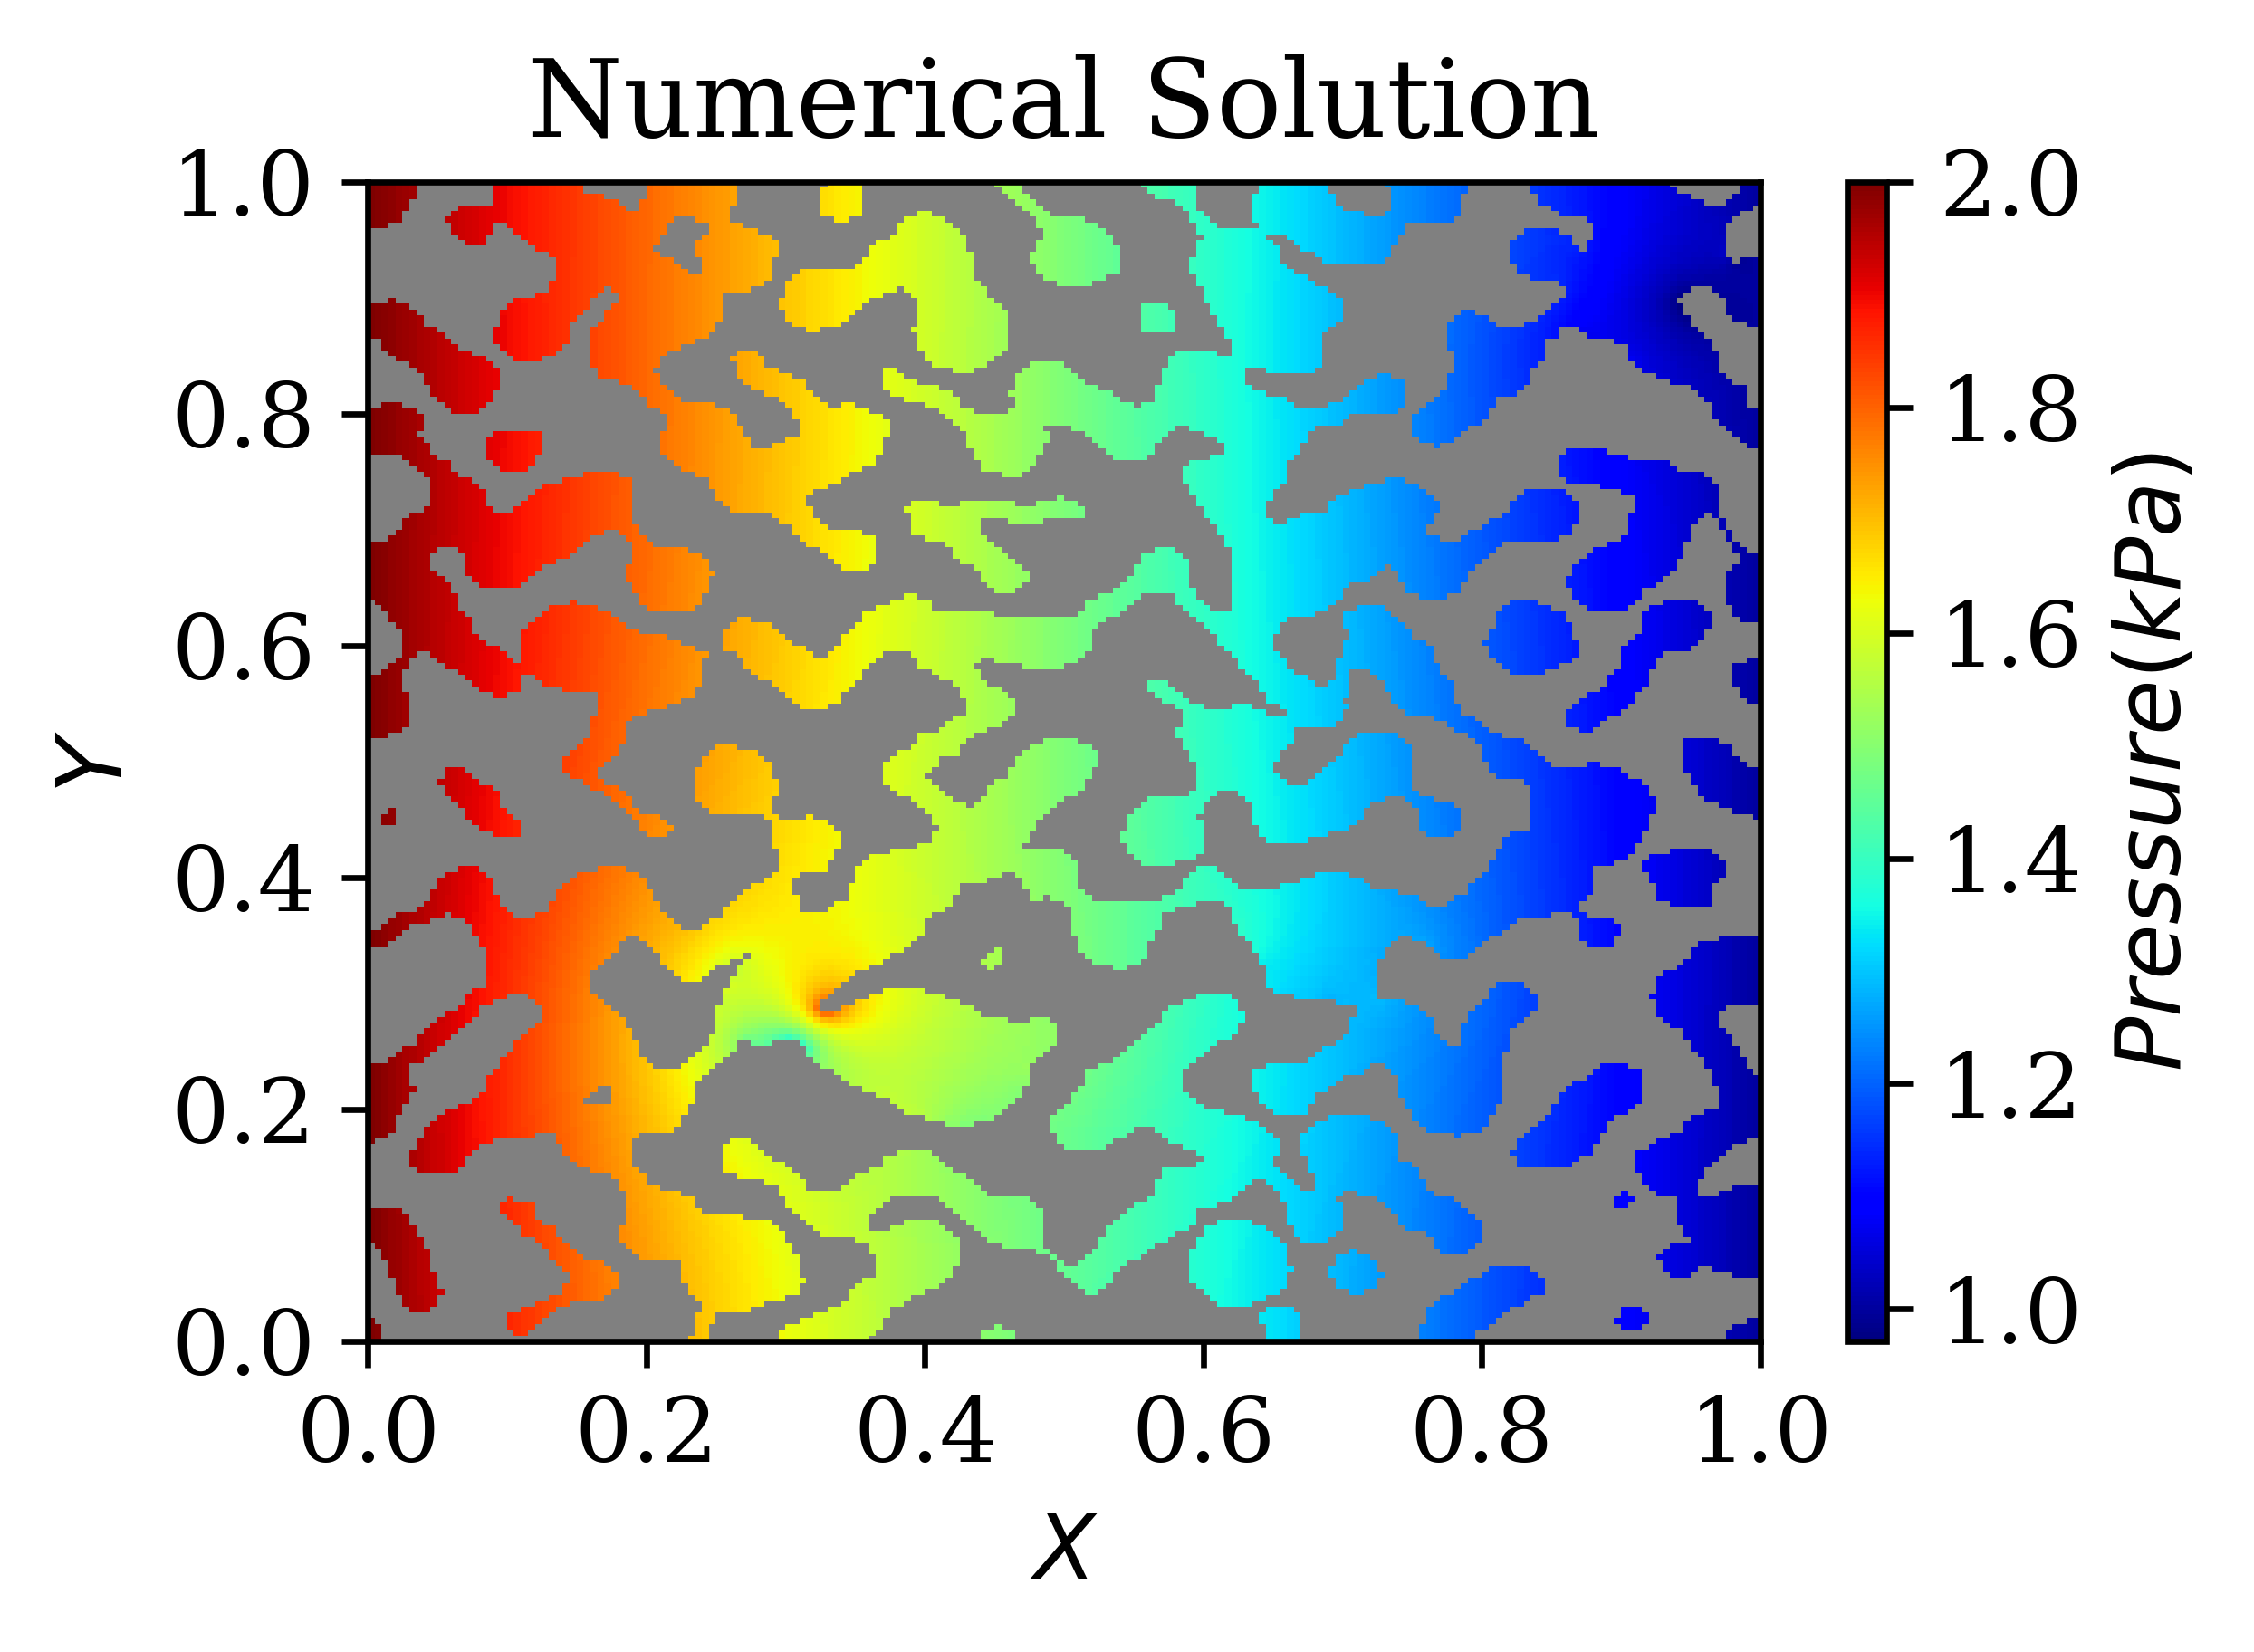

In [7]:
#%% Plot results
# title = 'Numerical Solution'
# fig_name = 'numerical_solution'
# cbar_lebel = "$Pressure (kPa)$"
# plot_2d_pressure_distribution(X, Y, Pressure, cbar_lebel, title, fig_name, results_dir)

# # Pressure line plots in the middle of the axis along the x-direction
# fig_name = 'numerical_solution_1d_pressure'
# title = 'Numerically simulated pressure'
# plot_pressure_along_x(X, Y, Pressure, title, fig_name, results_dir)

# pressure and masked soil skeleton
title = 'Numerical Solution'
fig_name = 'numerical_solution_masked'
cbar_lebel = "$Pressure (kPa)$"
masked_pressure = plot_2d_pressure_distribution_masked(X, Y, Pressure, perm_field, cbar_lebel, title, fig_name, results_dir)

# # Pressure line plots in the middle of the axis along the x direction (masked)
# fig_name = 'numerical_solution_1d_pressure_masked'
# title = 'Numerically simulated pressure'
# plot_pressure_along_x(X, Y, masked_pressure, title, fig_name, results_dir)

# save results
np.savez(results_dir + 'numerical_solution.npz', Pressure=Pressure, X=X, Y=Y, K=perm_field)